In [10]:
import numpy as np
import matplotlib.pyplot as plt
from jax import config
config.update("jax_enable_x64", True)
from jax import grad, jit, vmap
import jax.numpy as jnp
from gwb.omega_gw_jax import OmegaGWjax
# Set matplotlib parameters
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm, colors
from scipy.interpolate import interp1d
font = {'size': 16, 'family': 'serif'}
axislabelfontsize = 'large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=16)


In [2]:
kmin, kmax = 5e-5, 1e-2
k_arr = jnp.logspace(np.log10(kmin), np.log10(kmax), 50)

fac = 10
p_arr = jnp.geomspace(kmin/fac,kmax*fac,400)

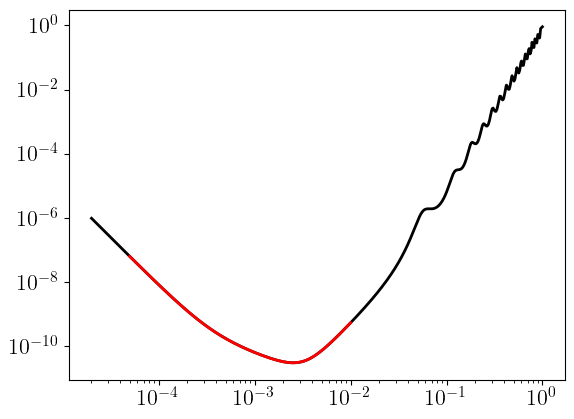

In [11]:
# bpl

f = k_arr #jnp.geomspace(5e-5, 1e-2, ksize)  # The frequencies to calculate Omega_GW
s = jnp.linspace(0, 1,20)  # First rescaled internal momentum
t = jnp.logspace(-5,5, 1000)  # Second rescaled internal momentum

## Expand t to add a new axis
t_expanded = jnp.expand_dims(t, axis=-1)
## Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(f), axis=-1)

@jit
def bpl(p,pstar=5e-4,n1=2,n2=-1,sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    # osc = (1 + 16.4*jnp.cos(1.4*jnp.log(p/1.))**2)
    return 1e-2 * pl1 * pl2 #*osc

@jit
def osc(p,pstar=5e-4,n1=2,n2=-1,sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    # osc = (1 + 16.4*jnp.cos(1.4*jnp.log(p/1.))**2)
    osc = (1 + 15*jnp.cos(1*jnp.log(p/2.5))**2)
    return 1e-3*pl1 * pl2 *osc

@jit
def peaked(p,pstar=9e-4,sigma=0.15,amp=1e-1,floor=7e-3):
    res = amp *(floor+ jnp.exp(-0.5*((jnp.log(p/pstar)/sigma)**2)))
    return 3e-1*res

gwb_calculator =  OmegaGWjax(s, t, f=f, kernel="RD", upsample=False)
h = 0.67
Lisa_data = np.load('Omeff_6l.npy')
freqs = Lisa_data['freq']
Omeff = Lisa_data['OmEff'] / h**2
fmin, fmax = freqs.min(), freqs.max()
Omeff_left, Omeff_right = Omeff[0], Omeff[-1]
noise_func = interp1d(freqs, Omeff, kind='linear', fill_value=(Omeff_left, Omeff_right), bounds_error=False)
plt.loglog(freqs, Omeff, label='LISA sensitivity', color='k', lw=2)
plt.loglog(f,noise_func(f), label='Interpolated LISA sensitivity', color='r', lw=2)

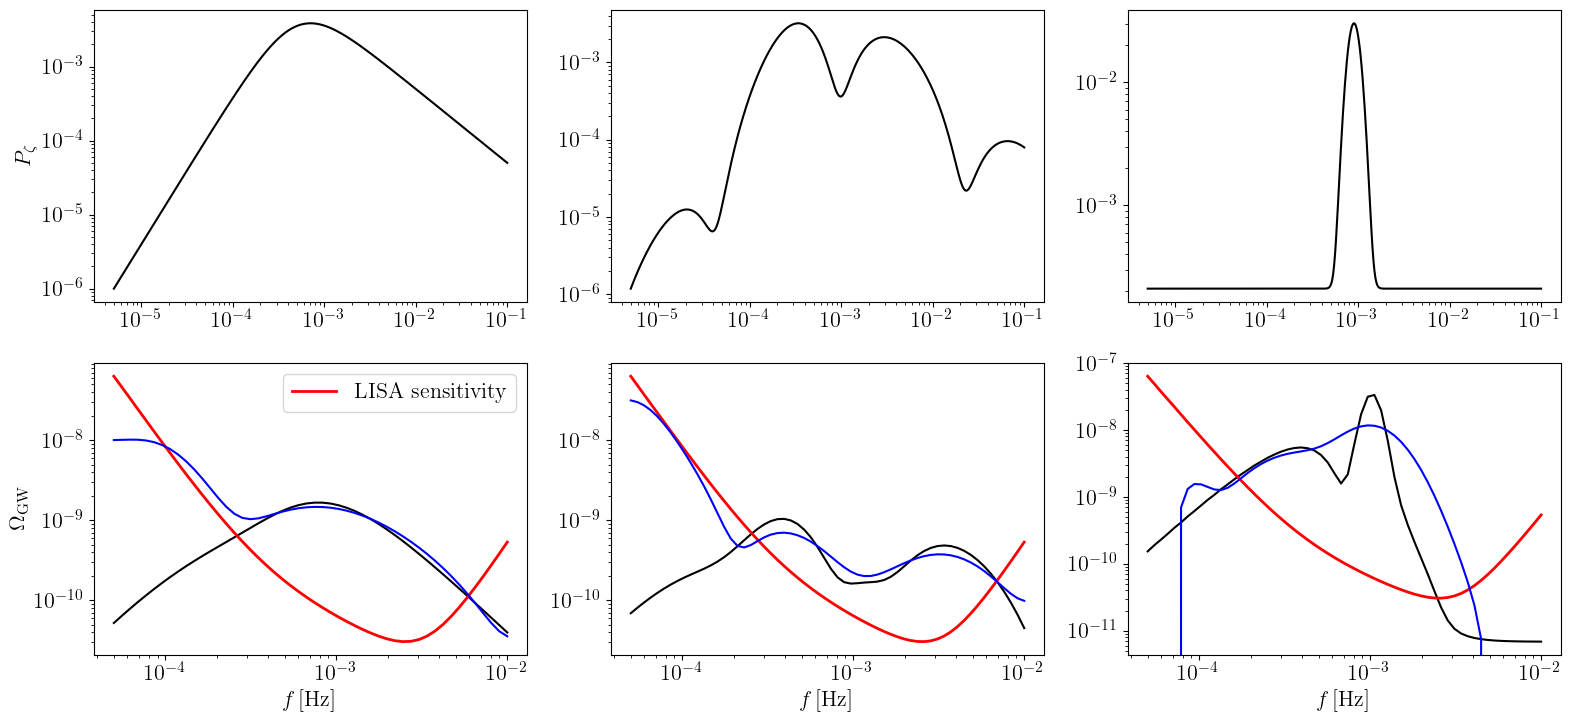

In [19]:
# noisy spectra
from scipy.ndimage import gaussian_filter1d

def gen_noisy_data(gw,freqs,filter_sigma=4):
    cov = noise_func(freqs)**2 * jnp.eye(len(freqs))
    res = gw + np.random.multivariate_normal(np.zeros_like(freqs),cov)
    res = gaussian_filter1d(res,filter_sigma)
    return res


spectra = [bpl,osc,peaked]

fig,ax = plt.subplots(2,3,figsize=(16,7.5),layout='tight',sharex='row')  
datadir = ['bpl_data.npz','osc_data.npz','peaked_data.npz']
for i in range(3):
    data = np.load(datadir[i])
    k = data['k']
    gw = 1e1*data['gw']
    noisy_gw = gen_noisy_data(gw,k)
    cov = data['cov']
    omks_sigma = np.sqrt(np.diag(cov))
    p_arr = data['p_arr']
    pz_amp = data['pz_amp']
    ax[1,i].loglog(k,gw,color='k')
    ax[1,i].loglog(k,noise_func(k), label='LISA sensitivity', color='r', lw=2)
    ax[1,i].loglog(k,noisy_gw,color='b')
    # ax[1,i].errorbar(k,gw,yerr=omks_sigma,color='k')
    ax
    ax[0,i].loglog(p_arr,pz_amp,color='k')
    # ax[0,i].set_title(['BPL','OSC','PEAKED'][i])
    ax[1,i].set_xscale('log')
    ax[1,i].set_yscale('log')
    ax[1,i].set_xlabel(r'$f\,{\rm [Hz]}$')
ax[0,0].set_ylabel(r'$P_{\zeta}$')
ax[1,0].set_ylabel(r'$\Omega_{\mathrm{GW}}$')
ax[1,0].legend()

In [9]:
@jit
def osc(p,pstar=5e-4,n1=2,n2=-1,sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    # osc = (1 + 16.4*jnp.cos(1.4*jnp.log(p/1.))**2)
    osc = (1 + 15*jnp.cos(1*jnp.log(p/2.5))**2)
    return 1e-3*pl1 * pl2 *osc
